In [ ]:
# !pip install torch
# !pip install datasets
# !pip install transformers
# !pip install scikit-learn
# !pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import confusion_matrix
from collections import Counter

import random


## Loading and Preprocessing the Dataset

In [6]:
dataset = load_dataset("karpathy/tiny_shakespeare")
text_data = dataset["train"][0]["text"]  # Entire Shakespeare text

# Tokenize by simple whitespace (for demonstration)
tokens = text_data.strip().split()

# Create vocab
vocab = set(tokens)
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# Convert tokens to indices
indexed_tokens = [word2idx[w] for w in tokens]

# Split: 80% train, 20% test
split_idx = int(0.8 * len(indexed_tokens))
train_data = indexed_tokens[:split_idx]
test_data = indexed_tokens[split_idx:]
print("Train samples:", len(train_data))
print("Test samples: ", len(test_data))

Vocabulary size: 23841
Train samples: 145999
Test samples:  36500


## Custom Dataset and Dataloaders

In [7]:
class ShakespeareDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length=5):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.seq_length]
        y = self.data[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.long)

seq_length = 5
batch_size = 128

train_dataset = ShakespeareDataset(train_data, seq_length=seq_length)
test_dataset = ShakespeareDataset(test_data, seq_length=seq_length)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True
)

## Vanilla RNN Class

In [8]:
class VanillaRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, pretrained_weights=None, freeze_embed=False):
        super(VanillaRNN, self).__init__()
        # If pretrained_weights is provided, use that for the embedding
        self.embed = nn.Embedding(vocab_size, embed_size)
        if pretrained_weights is not None:
            # Initialize embedding with these weights
            self.embed.weight.data.copy_(torch.from_numpy(pretrained_weights))
            if freeze_embed:
                self.embed.weight.requires_grad = False

        self.hidden_size = hidden_size
        self.W_xh = nn.Linear(embed_size, hidden_size)
        self.W_hh = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.W_hy = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden):
        """
        x: (batch_size, seq_length)
        hidden: (batch_size, hidden_size)
        """
        batch_size, seq_len = x.shape
        embedded = self.embed(x)  # (batch_size, seq_length, embed_size)

        h_t = hidden
        for t in range(seq_len):
            x_t = embedded[:, t, :]
            h_t = self.tanh(self.W_xh(x_t) + self.W_hh(h_t))

        out = self.W_hy(h_t)  # (batch_size, vocab_size)
        return out, h_t

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

## Training and Evaluation Functions

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def compute_accuracy(logits, targets):
    """
    logits: (batch_size, vocab_size)
    targets: (batch_size)
    """
    _, preds = torch.max(logits, dim=1)
    correct = (preds == targets).sum().item()
    total = targets.size(0)
    return correct, total

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_words = 0

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            hidden = model.init_hidden(x_batch.size(0)).to(device)
            out, hidden = model(x_batch, hidden)
            loss = criterion(out, y_batch)

            total_loss += loss.item() * x_batch.size(0)
            c, t = compute_accuracy(out, y_batch)
            total_correct += c
            total_words += t

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / total_words
    perplexity = np.exp(avg_loss)
    return avg_loss, accuracy, perplexity

def train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=5
):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    train_perplexities, test_perplexities = [], []

    best_test_loss = float("inf")
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_words = 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            hidden = model.init_hidden(x_batch.size(0)).to(device)
            out, hidden = model(x_batch, hidden)
            loss = criterion(out, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * x_batch.size(0)
            c, t = compute_accuracy(out, y_batch)
            epoch_correct += c
            epoch_words += t

        train_loss = epoch_loss / len(train_loader.dataset)
        train_acc = epoch_correct / epoch_words
        train_ppl = np.exp(train_loss)

        test_loss, test_acc, test_ppl = evaluate(model, test_loader, criterion)

        # Track stats
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_perplexities.append(train_ppl)
        test_perplexities.append(test_ppl)

        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict()

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, PPL: {train_ppl:.2f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, PPL: {test_ppl:.2f}")

    # Load best model state
    model.load_state_dict(best_model_state)

    return (train_losses, test_losses,
            train_accuracies, test_accuracies,
            train_perplexities, test_perplexities)

Device: cuda


## Model with Random Embeddings

In [10]:
embed_size = 50
hidden_size = 128
lr = 0.001
num_epochs = 10

random_model = VanillaRNN(
    vocab_size=vocab_size,
    embed_size=embed_size,
    hidden_size=hidden_size,
    pretrained_weights=None,
    freeze_embed=False  # Not applicable here; no pretrained to freeze
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(random_model.parameters(), lr=lr)

print("\n=== Training Baseline RNN with Random Embeddings ===")
random_train_stats = train_model(
    random_model, train_loader, test_loader, criterion, optimizer, num_epochs
)

(rnd_train_losses, rnd_test_losses,
 rnd_train_accs, rnd_test_accs,
 rnd_train_ppls, rnd_test_ppls) = random_train_stats


=== Training Baseline RNN with Random Embeddings ===
Epoch [1/10] Train Loss: 7.7367, Acc: 0.0434, PPL: 2290.87 | Test Loss: 7.6896, Acc: 0.0538, PPL: 2185.54
Epoch [2/10] Train Loss: 6.8357, Acc: 0.0657, PPL: 930.48 | Test Loss: 7.7501, Acc: 0.0606, PPL: 2321.77
Epoch [3/10] Train Loss: 6.2930, Acc: 0.0755, PPL: 540.75 | Test Loss: 7.8486, Acc: 0.0635, PPL: 2562.02
Epoch [4/10] Train Loss: 5.8246, Acc: 0.0830, PPL: 338.52 | Test Loss: 8.0098, Acc: 0.0654, PPL: 3010.18
Epoch [5/10] Train Loss: 5.3999, Acc: 0.0969, PPL: 221.38 | Test Loss: 8.1598, Acc: 0.0637, PPL: 3497.40
Epoch [6/10] Train Loss: 5.0121, Acc: 0.1253, PPL: 150.22 | Test Loss: 8.3393, Acc: 0.0605, PPL: 4185.29
Epoch [7/10] Train Loss: 4.6589, Acc: 0.1616, PPL: 105.52 | Test Loss: 8.5186, Acc: 0.0585, PPL: 5007.27
Epoch [8/10] Train Loss: 4.3439, Acc: 0.1996, PPL: 77.01 | Test Loss: 8.7055, Acc: 0.0578, PPL: 6035.79
Epoch [9/10] Train Loss: 4.0632, Acc: 0.2375, PPL: 58.16 | Test Loss: 8.8794, Acc: 0.0554, PPL: 7182.46
Ep

## Glove Initiated Embeddings

In [11]:
glove_dim = 50
glove_path = "glove.6B.50d.txt"  # Adjust path as necessary

# 6.1 Load GloVe Vectors
glove_embeddings = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        glove_embeddings[word] = vector

## Building Embedding Matrix

In [12]:
embedding_matrix = np.zeros((vocab_size, glove_dim), dtype="float32")

for word, idx in word2idx.items():
    # GloVe is typically all lowercase, or might need special handling for punctuation
    # For this simple approach, let's try the exact word first,
    # or fallback to lowercased if needed.
    # If still not found, we use random normal initialization.

    # Attempt exact match
    vec = glove_embeddings.get(word, None)
    if vec is None:
        # Attempt lowercased match
        vec = glove_embeddings.get(word.lower(), None)
    if vec is not None:
        embedding_matrix[idx] = vec
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(glove_dim,))

## Create and Train the RNN with GloVe Initialization

In [13]:
glove_model = VanillaRNN(
    vocab_size=vocab_size,
    embed_size=glove_dim,
    hidden_size=hidden_size,
    pretrained_weights=embedding_matrix,
    freeze_embed=False  # If True, embeddings won't update
).to(device)

glove_optimizer = optim.Adam(glove_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

print("\n=== Training RNN with GloVe-Initialized Embeddings ===")
glove_train_stats = train_model(
    glove_model, train_loader, test_loader, criterion, glove_optimizer, num_epochs
)

(glv_train_losses, glv_test_losses,
 glv_train_accs, glv_test_accs,
 glv_train_ppls, glv_test_ppls) = glove_train_stats


=== Training RNN with GloVe-Initialized Embeddings ===
Epoch [1/10] Train Loss: 7.5633, Acc: 0.0502, PPL: 1926.27 | Test Loss: 7.4584, Acc: 0.0649, PPL: 1734.39
Epoch [2/10] Train Loss: 6.6871, Acc: 0.0777, PPL: 801.98 | Test Loss: 7.5082, Acc: 0.0722, PPL: 1822.97
Epoch [3/10] Train Loss: 6.2105, Acc: 0.0887, PPL: 497.93 | Test Loss: 7.6266, Acc: 0.0728, PPL: 2052.10
Epoch [4/10] Train Loss: 5.7784, Acc: 0.0989, PPL: 323.24 | Test Loss: 7.7597, Acc: 0.0748, PPL: 2344.11
Epoch [5/10] Train Loss: 5.3665, Acc: 0.1106, PPL: 214.12 | Test Loss: 7.8884, Acc: 0.0730, PPL: 2666.08
Epoch [6/10] Train Loss: 4.9764, Acc: 0.1346, PPL: 144.95 | Test Loss: 8.0695, Acc: 0.0712, PPL: 3195.48
Epoch [7/10] Train Loss: 4.6076, Acc: 0.1703, PPL: 100.24 | Test Loss: 8.2556, Acc: 0.0697, PPL: 3849.08
Epoch [8/10] Train Loss: 4.2633, Acc: 0.2136, PPL: 71.05 | Test Loss: 8.4637, Acc: 0.0661, PPL: 4739.44
Epoch [9/10] Train Loss: 3.9496, Acc: 0.2564, PPL: 51.91 | Test Loss: 8.6413, Acc: 0.0633, PPL: 5660.84


## Compare Loss & Accuracy Curves

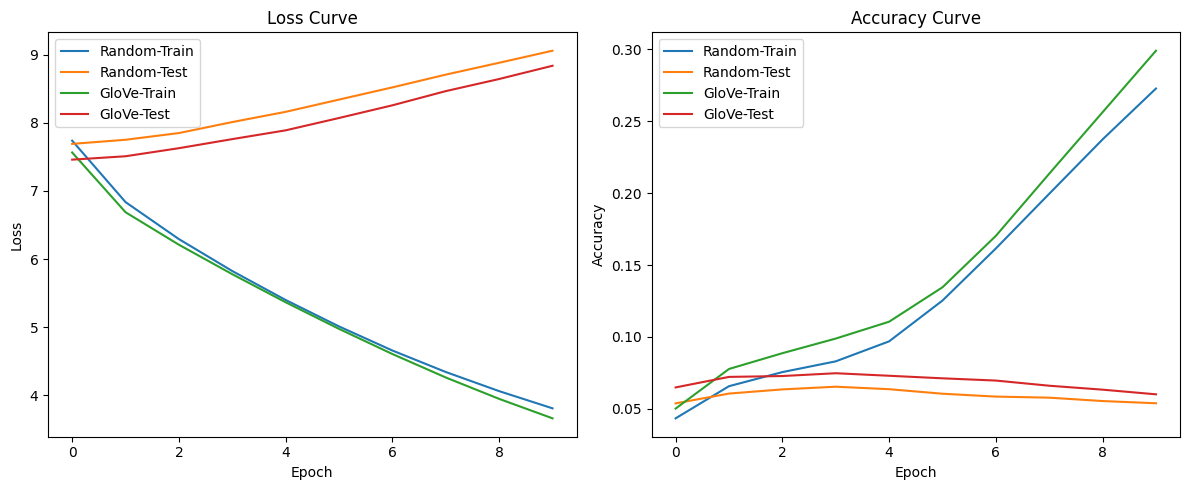

In [14]:

plt.figure(figsize=(12, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(rnd_train_losses, label="Random-Train")
plt.plot(rnd_test_losses, label="Random-Test")
plt.plot(glv_train_losses, label="GloVe-Train")
plt.plot(glv_test_losses, label="GloVe-Test")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(rnd_train_accs, label="Random-Train")
plt.plot(rnd_test_accs, label="Random-Test")
plt.plot(glv_train_accs, label="GloVe-Train")
plt.plot(glv_test_accs, label="GloVe-Test")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

## Final Evaluation

In [15]:
def final_evaluation_report(model, data_loader, name="Model"):
    loss, acc, ppl = evaluate(model, data_loader, nn.CrossEntropyLoss())
    print(f"{name}: Loss={loss:.4f}, Accuracy={acc:.4f}, Perplexity={ppl:.2f}")
    return loss, acc, ppl

rnd_loss, rnd_acc, rnd_ppl = final_evaluation_report(random_model, test_loader, "Random-Emb Model")
glv_loss, glv_acc, glv_ppl = final_evaluation_report(glove_model, test_loader, "GloVe-Emb Model")

print("\nComparison Table:")
print("---------------------------------------------------------")
print("Embedding Type    |  Word-Level Accuracy  |  Perplexity")
print("---------------------------------------------------------")
print(f"Random Embeddings |        {rnd_acc:.4f}         |    {rnd_ppl:.2f}")
print(f"GloVe Embeddings  |        {glv_acc:.4f}         |    {glv_ppl:.2f}")

Random-Emb Model: Loss=9.0562, Accuracy=0.0539, Perplexity=8571.30
GloVe-Emb Model: Loss=8.8357, Accuracy=0.0601, Perplexity=6875.16

Comparison Table:
---------------------------------------------------------
Embedding Type    |  Word-Level Accuracy  |  Perplexity
---------------------------------------------------------
Random Embeddings |        0.0539         |    8571.30
GloVe Embeddings  |        0.0601         |    6875.16


## Confusion Matrix on a Subset of Words

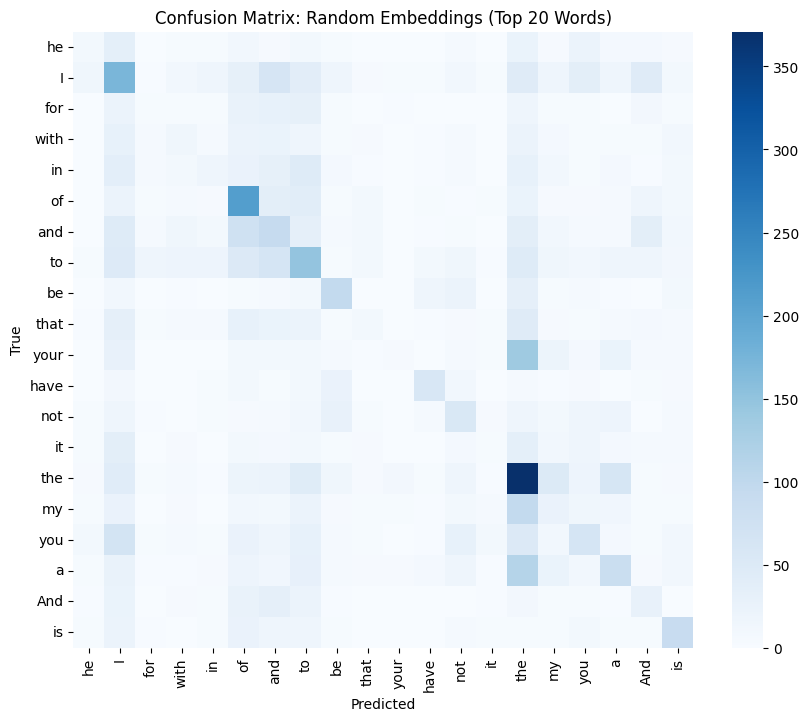

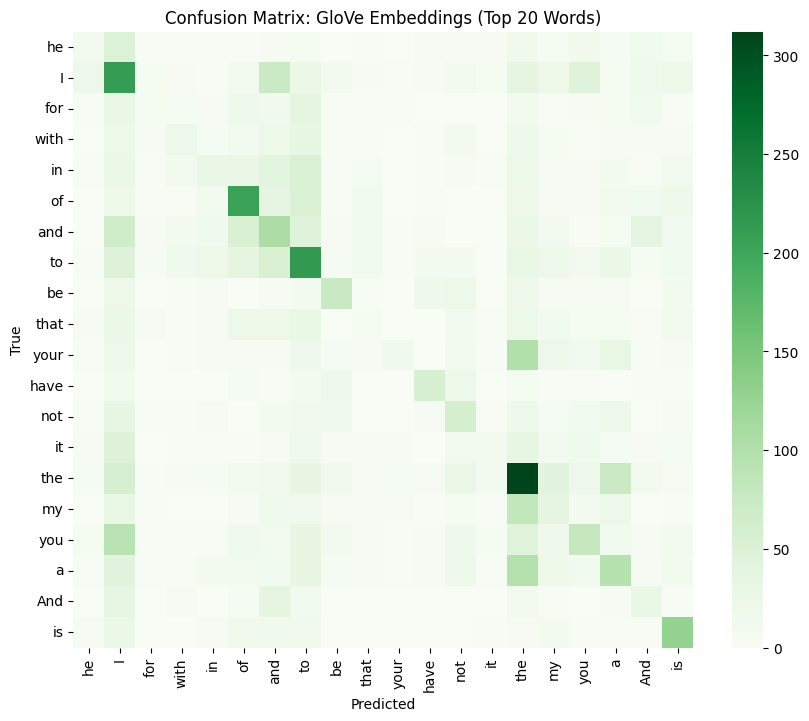

In [16]:
num_classes_to_show = 20  # top 20 frequent words
test_word_counts = Counter(test_data)
top_20_word_indices = [w for w, _ in test_word_counts.most_common(num_classes_to_show)]
top_20_idx_set = set(top_20_word_indices)

def get_confusion_matrix(model, data_loader, top_indices):
    model.eval()
    y_true_list, y_pred_list = [], []

    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            out, _ = model(x_batch, model.init_hidden(x_batch.size(0)).to(device))
            _, preds = torch.max(out, dim=1)

            for yt, yp in zip(y_batch, preds):
                if yt.item() in top_indices:  # only keep those in top subset
                    y_true_list.append(yt.item())
                    y_pred_list.append(yp.item())

    return y_true_list, y_pred_list

y_true_rnd, y_pred_rnd = get_confusion_matrix(random_model, test_loader, top_20_idx_set)
y_true_glv, y_pred_glv = get_confusion_matrix(glove_model, test_loader, top_20_idx_set)

if len(y_true_rnd) > 0:
    cm_rnd = confusion_matrix(y_true_rnd, y_pred_rnd, labels=list(top_20_idx_set))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_rnd, annot=False, fmt="d",
                xticklabels=[idx2word[i] for i in top_20_idx_set],
                yticklabels=[idx2word[i] for i in top_20_idx_set],
                cmap="Blues")
    plt.title("Confusion Matrix: Random Embeddings (Top 20 Words)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
else:
    print("Not enough matching samples to plot confusion matrix for Random Embeddings.")

if len(y_true_glv) > 0:
    cm_glv = confusion_matrix(y_true_glv, y_pred_glv, labels=list(top_20_idx_set))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_glv, annot=False, fmt="d",
                xticklabels=[idx2word[i] for i in top_20_idx_set],
                yticklabels=[idx2word[i] for i in top_20_idx_set],
                cmap="Greens")
    plt.title("Confusion Matrix: GloVe Embeddings (Top 20 Words)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
else:
    print("Not enough matching samples to plot confusion matrix for GloVe Embeddings.")